<a href="https://colab.research.google.com/github/jhChoi1997/EE488_AI_Convergence_Capstone_Design_Anomaly_Detection_2022spring/blob/main/Experiment1/Introduction_to_Anomaly_Detection_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EE 488 AI Convergence Capstone Design : Anomaly Detection**
## **practice 1-1 : Introduction to Anomaly Detection (Reconstruction)**
Anomaly detection can be done by various pretext tasks. In this session, we will do anomaly detection with reconstruction as a pretext task on the MNIST dataset. 💻

In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
import matplotlib.pyplot as plt
import torchsummary
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


You can change the hyperparameter below.
Parameter 'ANOMALY_NUM' means which number to set as an anomaly.

In [3]:
LATENT_DIM = 32
EPOCHS = 100
BATCH = 32
ANOMALY_NUM = 9

The dataset for anomaly detection is composed of normal data and anomaly data. Normal data can be seen in the train, validation, and test dataset, but anomaly data is not in the train dataset. Here 0 to 8 will be used as normal data, and 9 will be used as anomaly data.

In [4]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

train_normal = [mnist_train[i][0].numpy() for i, v in enumerate(mnist_train) if v[1] != ANOMALY_NUM]

train_dataset = torch.Tensor(train_normal)

unseen_x = torch.tensor([v[0].numpy() for v in mnist_test])
unseen_y = torch.tensor([0 if v[1] != ANOMALY_NUM else 1 for v in mnist_test])

val_x = unseen_x[:int(len(unseen_x) / 2)]
val_y = unseen_y[:int(len(unseen_y) / 2)]

test_x = unseen_x[int(len(unseen_x) / 2):]
test_y = unseen_y[int(len(unseen_y) / 2):]

val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


Dataset length is like below.

In [5]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

54051
5000
5000


You will use Auto Encoder for practice

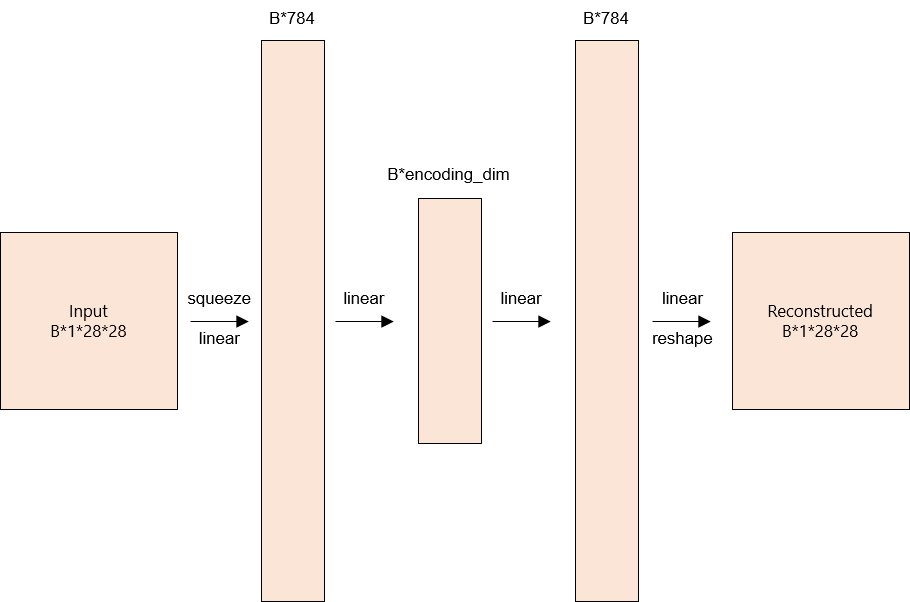

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoding_dim = encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, self.encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dim, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = x.reshape(x.size(0), -1)
        out = self.encoder(out)
        out = self.decoder(out)
        out = out.view(x.size())
        return out

In [ ]:
model = AutoEncoder(64).to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


In [ ]:
loss_fn = nn.MSELoss()
anomaly_score = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        X = X.to(device)

        pred = model(X)
        loss = loss_fn(pred, X)

        for idata in range(pred.shape[0]):

            iloss = loss_fn(pred[idata,:,:], X[idata,:,:])
            losses.append(iloss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    losses = [i.item() for i in losses]
    return np.mean(losses)

Anomaly score is calculated in validation and test. Reconstruction error is commonly used as an anomaly score when using reconstruction as a pretext task. Since the model is trained with normal data, the model may not reconstruct anomaly data well, so the anomaly score of anomaly data will be higher than the anomaly score of normal data. And using different distributions of anomaly score, AUC (Area Under Cover) can be calculated.

In [ ]:
def test(dataloader, model, loss_fn, anomaly_score, draw_mode = False):
    model.eval()

    y_true, y_pred = [], []

    normal_loss = []
    anomaly_loss = []

    with torch.no_grad():
      
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)

            for idata in range(output.shape[0]):

                loss = loss_fn(output[idata,:,:], X[idata,:,:])
                if y[idata] == 0:
                    normal_loss.append(loss)
                elif y[idata] == 1:
                    anomaly_loss.append(loss)
            
            score = torch.mean(anomaly_score(X, output), (1, 2, 3))

            y_true.extend(y.tolist())
            y_pred.extend(score.tolist())

    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')


    print(f'AUC: {roc_auc:>0.3f}')
    normal_loss = [i.item() for i in normal_loss]
    anomaly_loss = [i.item() for i in anomaly_loss]
    normal_loss_mean = np.mean(normal_loss)
    anomaly_loss_mean = np.mean(anomaly_loss)
    print(f'normal loss : {normal_loss_mean}')
    print(f'anomaly loss : {anomaly_loss_mean}')
    return roc_auc.item(), normal_loss_mean, anomaly_loss_mean

See how reconstruction loss and AUC changes during training.
Loss is calculated during train and AUC is calculated during validation.

In [ ]:
aucs = []
train_normal_losses = []
val_normal_losses = []
val_anomaly_losses = []
best_auc = 0
best_model = model.to(device)
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_normal_loss = train(train_dataloader, model, loss_fn, optimizer)
    auc, val_normal_loss, val_anomaly_loss = test(val_dataloader, model, loss_fn, anomaly_score)
    train_normal_losses.append(train_normal_loss)
    aucs.append(auc)
    val_normal_losses.append(val_normal_loss)
    val_anomaly_losses.append(val_anomaly_loss)
    if best_auc < auc:
      best_model = model
      best_auc = auc

Epoch 1
-------------------------------
loss: 0.231758  [    0/48646]
loss: 0.043527  [ 9600/48646]
loss: 0.031136  [19200/48646]
loss: 0.023130  [28800/48646]
loss: 0.020920  [38400/48646]
loss: 0.013922  [48000/48646]
AUC: 0.544
normal loss : 0.015525861517744488
anomaly loss : 0.01655070939943051
Epoch 2
-------------------------------
loss: 0.015210  [    0/48646]
loss: 0.016205  [ 9600/48646]
loss: 0.012592  [19200/48646]
loss: 0.009935  [28800/48646]
loss: 0.010562  [38400/48646]
loss: 0.007490  [48000/48646]
AUC: 0.551
normal loss : 0.008824474307246939
anomaly loss : 0.009510364104062318
Epoch 3
-------------------------------
loss: 0.008742  [    0/48646]
loss: 0.009586  [ 9600/48646]
loss: 0.007517  [19200/48646]
loss: 0.006826  [28800/48646]
loss: 0.007542  [38400/48646]
loss: 0.005677  [48000/48646]
AUC: 0.543
normal loss : 0.006787109993118585
anomaly loss : 0.007187825539417995
Epoch 4
-------------------------------
loss: 0.006912  [    0/48646]
loss: 0.007274  [ 9600/48

<Figure size 432x288 with 0 Axes>

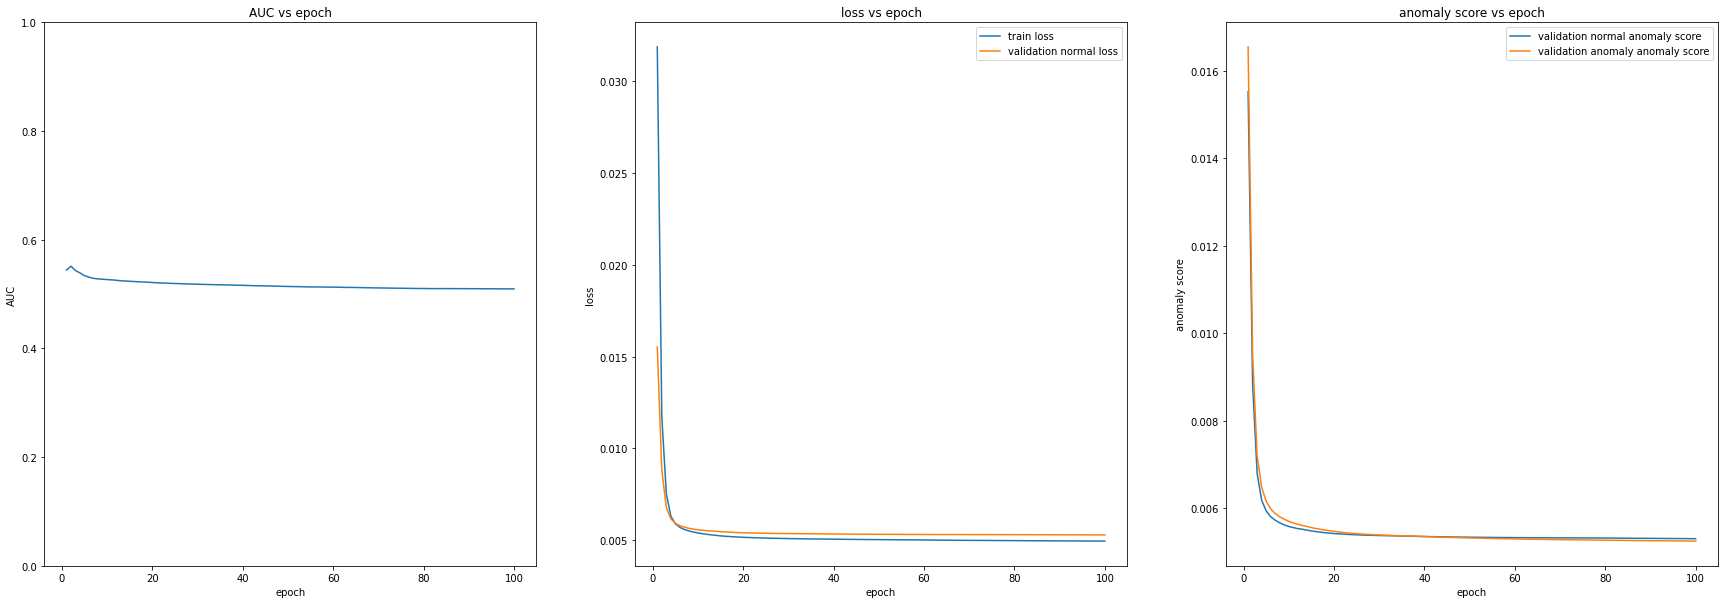

In [ ]:
plt.clf()
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(list(range(1,len(aucs)+1)),aucs)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(1,3,2)
plt.plot(list(range(1,len(train_normal_losses)+1)),train_normal_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'])

plt.subplot(1,3,3)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.plot(list(range(1,len(val_anomaly_losses)+1)),val_anomaly_losses)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal anomaly score','validation anomaly anomaly score'])

Let's see performance on the test data.

AUC: 0.467
normal loss : 0.0046311717000436904
anomaly loss : 0.004268056710187825


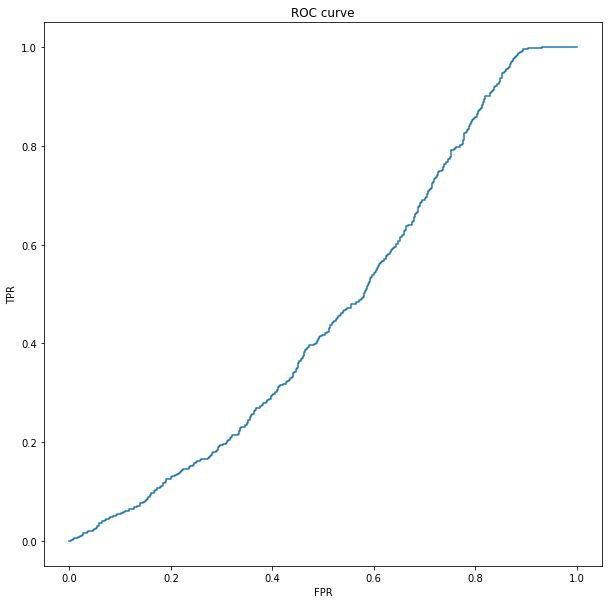

In [ ]:
auc, _, _ = test(test_dataloader, best_model, loss_fn, anomaly_score, True)

Below code plots figure of the original input image and reconstructed image.

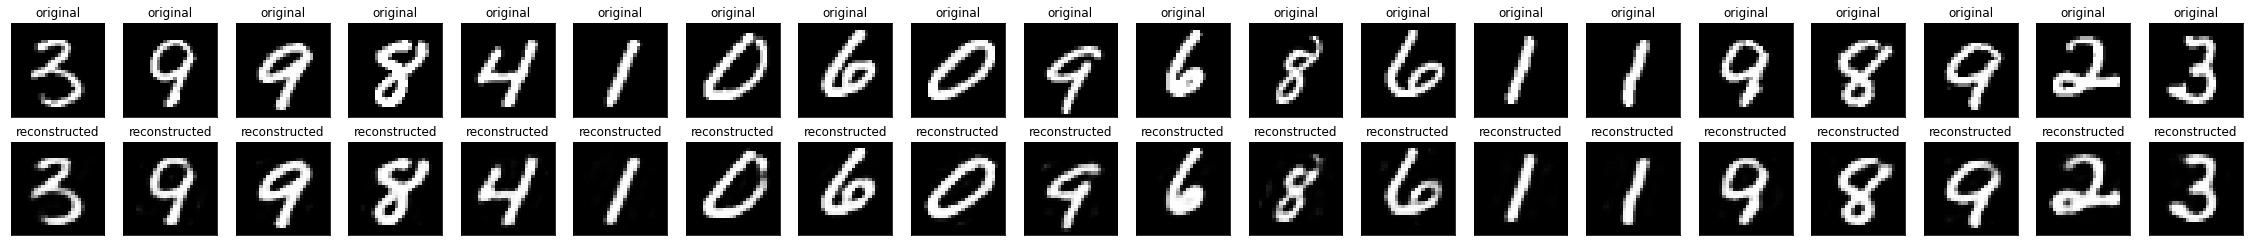

In [ ]:
n = 20
plt.figure(figsize=(2*n, 4))

for i in range(n):
  input_image = test_dataset[i][0].to(device)
  output_image = best_model(input_image.unsqueeze(0))

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(input_image[0].cpu())
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(output_image[0].squeeze().detach().cpu())
  plt.title('reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

As you see, normal data (0 to 8) is reconstructed well compared to anomaly data (9). 

This means normal data have lower reconstruction error, which is anomaly score, and anomaly data have higher reconstruction error.

Using this difference of anomaly score, anomaly detection can be done.